## ADIM 1: GEREKLİ KÜTÜPHANELERİN YÜKLENMESİ

In [1]:
# Tüm gerekli kütüphaneleri import edelim
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import backend as K
from sklearn.model_selection import train_test_split
import pandas as pd
import json
import time
from PIL import Image
from skimage import exposure
import albumentations as A
from scipy import stats
from math import pi

print("✅ Tüm kütüphaneler başarıyla yüklendi!")

✅ Tüm kütüphaneler başarıyla yüklendi!


## ADIM 2: VERİ SETİNİN YÜKLENMESİ VE İNCELENMESİ

📁 Veri seti başarıyla yüklendi!
📊 Toplam görüntü sayısı: 1000
📊 Toplam maske sayısı: 1000
📝 İlk 5 görüntü: ['cju0qkwl35piu0993l0dewei2.jpg', 'cju0qoxqj9q6s0835b43399p4.jpg', 'cju0qx73cjw570799j4n5cjze.jpg', 'cju0roawvklrq0799vmjorwfv.jpg', 'cju0rx1idathl0835detmsp84.jpg']

📐 İLK 3 GÖRÜNTÜ BOYUTLARI:
   Görüntü 1: (529, 622, 3), Maske 1: (529, 622, 3)
   Görüntü 2: (1070, 1348, 3), Maske 2: (1070, 1348, 3)
   Görüntü 3: (529, 619, 3), Maske 3: (529, 619, 3)

🖼️  İLK 3 GÖRÜNTÜ VE MASKE GÖSTERİLİYOR...


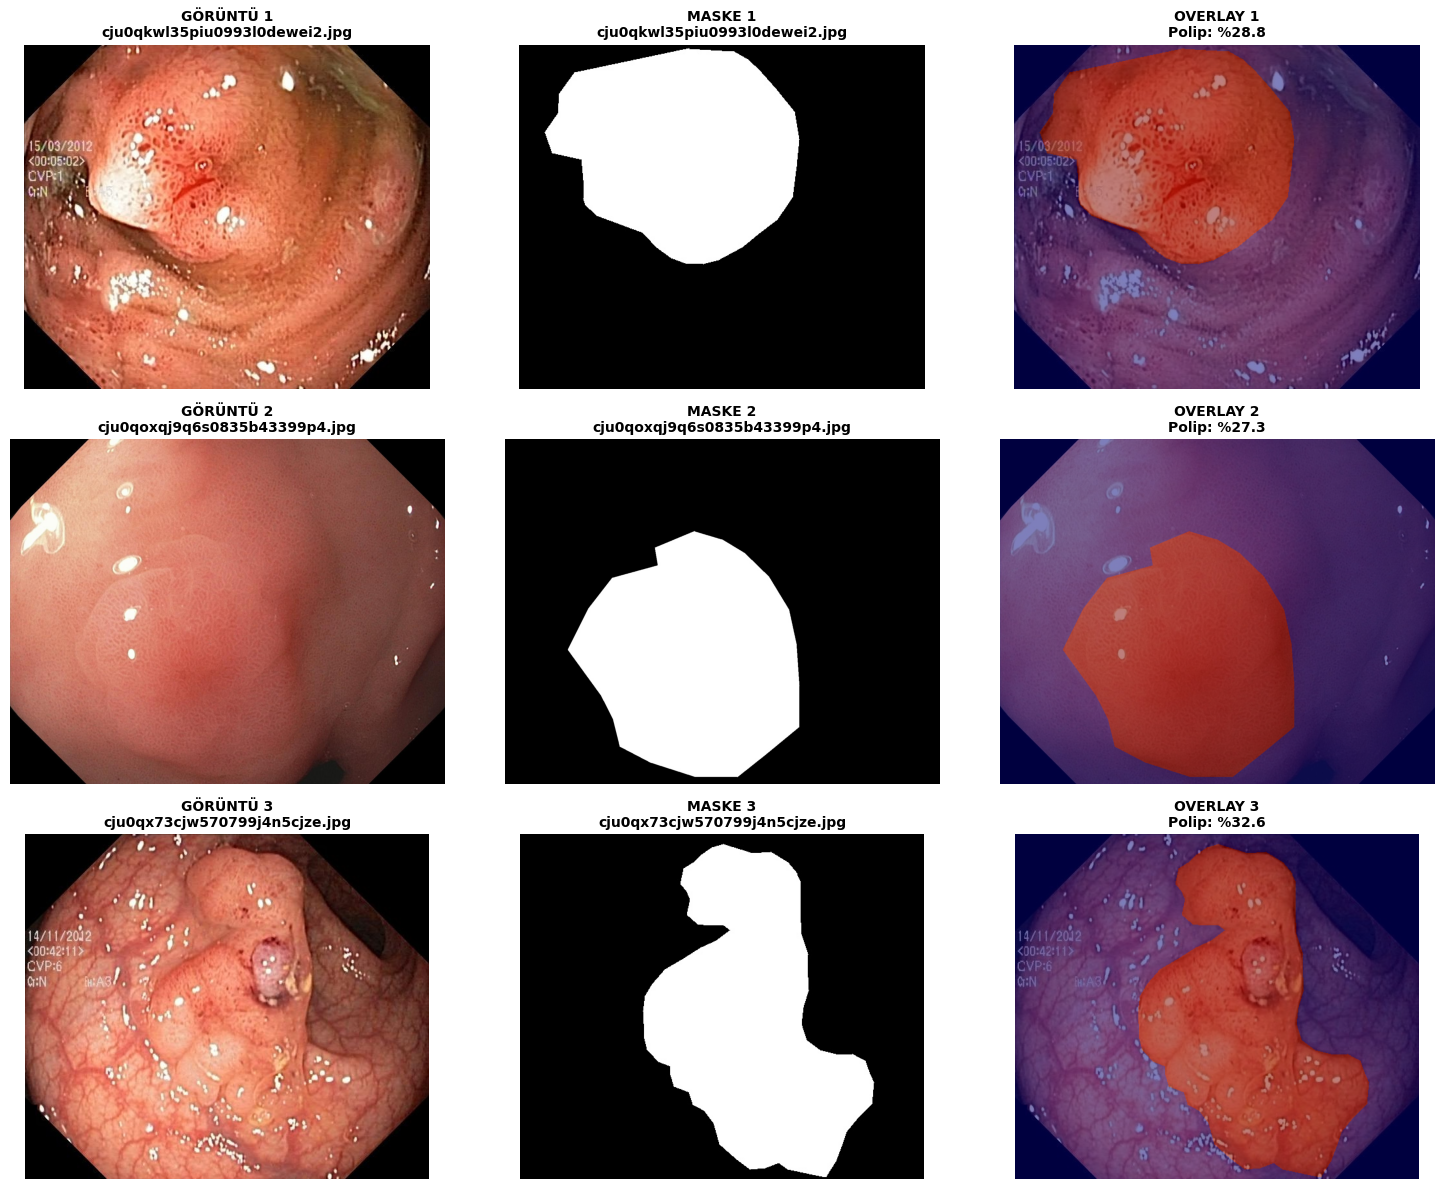


📊 İLK 3 GÖRÜNTÜ MASKE İSTATİSTİKLERİ:
📊 Görüntü 1: cju0qkwl35piu0993l0dewei2.jpg
   • Boyut: 529x622
   • Toplam piksel: 329,038
   • Polip pikseli: 94,684 (%28.78)
   • Arkaplan: 234,354

📊 Görüntü 2: cju0qoxqj9q6s0835b43399p4.jpg
   • Boyut: 1070x1348
   • Toplam piksel: 1,442,360
   • Polip pikseli: 393,974 (%27.31)
   • Arkaplan: 1,048,386

📊 Görüntü 3: cju0qx73cjw570799j4n5cjze.jpg
   • Boyut: 529x619
   • Toplam piksel: 327,451
   • Polip pikseli: 106,837 (%32.63)
   • Arkaplan: 220,614


In [2]:
# Veri seti yapısını kontrol edelim ve ilk 3 örneği gösterelim
def check_dataset():
    images_dir = "Kvasir-SEG/images/"
    masks_dir = "Kvasir-SEG/masks/"
    
    if os.path.exists(images_dir) and os.path.exists(masks_dir):
        image_files = sorted(os.listdir(images_dir))
        mask_files = sorted(os.listdir(masks_dir))
        
        print(f"📁 Veri seti başarıyla yüklendi!")
        print(f"📊 Toplam görüntü sayısı: {len(image_files)}")
        print(f"📊 Toplam maske sayısı: {len(mask_files)}")
        print(f"📝 İlk 5 görüntü: {image_files[:5]}")
        
        # İlk 3 görüntüyü kontrol et
        print(f"\n📐 İLK 3 GÖRÜNTÜ BOYUTLARI:")
        for i in range(3):
            sample_image = cv2.imread(os.path.join(images_dir, image_files[i]))
            sample_mask = cv2.imread(os.path.join(masks_dir, mask_files[i]))
            print(f"   Görüntü {i+1}: {sample_image.shape}, Maske {i+1}: {sample_mask.shape}")
        
        # İlk 3 görüntü ve maskeyi göster
        print(f"\n🖼️  İLK 3 GÖRÜNTÜ VE MASKE GÖSTERİLİYOR...")
        
        # 3x3 grid oluştur (3 görüntü × 3 kolon)
        fig, axes = plt.subplots(3, 3, figsize=(15, 12))
        
        for i in range(3):  # İlk 3 görüntü için
            
            img_path = os.path.join(images_dir, image_files[i])
            mask_path = os.path.join(masks_dir, mask_files[i])
            
            image = cv2.imread(img_path)
            image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            mask_gray = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
            
            total_pixels = mask_gray.size
            polyp_pixels = np.sum(mask_gray > 0)
            polyp_percentage = (polyp_pixels / total_pixels) * 100
            
            # 1. Orijinal Görüntü
            axes[i, 0].imshow(image_rgb)
            axes[i, 0].set_title(f'GÖRÜNTÜ {i+1}\n{image_files[i]}', 
                               fontsize=10, fontweight='bold')
            axes[i, 0].axis('off')
            
            # 2. Maske
            axes[i, 1].imshow(mask_gray, cmap='gray')
            axes[i, 1].set_title(f'MASKE {i+1}\n{mask_files[i]}', 
                               fontsize=10, fontweight='bold')
            axes[i, 1].axis('off')
            
            # 3. Overlay
            axes[i, 2].imshow(image_rgb)
            axes[i, 2].imshow(mask_gray, alpha=0.5, cmap='jet')
            axes[i, 2].set_title(f'OVERLAY {i+1}\nPolip: %{polyp_percentage:.1f}', 
                               fontsize=10, fontweight='bold')
            axes[i, 2].axis('off')
        
        plt.tight_layout()
        plt.show()
        
        # Tüm istatistikleri göster
        print(f"\n📊 İLK 3 GÖRÜNTÜ MASKE İSTATİSTİKLERİ:")
        print("=" * 60)
        for i in range(3):
            mask_path = os.path.join(masks_dir, mask_files[i])
            mask_gray = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
            
            total_pixels = mask_gray.size
            polyp_pixels = np.sum(mask_gray > 0)
            polyp_percentage = (polyp_pixels / total_pixels) * 100
            
            print(f"📊 Görüntü {i+1}: {image_files[i]}")
            print(f"   • Boyut: {mask_gray.shape[0]}x{mask_gray.shape[1]}")
            print(f"   • Toplam piksel: {total_pixels:,}")
            print(f"   • Polip pikseli: {polyp_pixels:,} (%{polyp_percentage:.2f})")
            print(f"   • Arkaplan: {total_pixels - polyp_pixels:,}")
            if i < 2:
                print()
        
        return True
    else:
        print("❌ Veri seti klasörleri bulunamadı!")
        return False

# Veri setini kontrol et
dataset_loaded = check_dataset()

## ADIM 3: VERİ ÖN İŞLEME ADIMLARI

🔄 Gelişmiş ön işleme ile görüntüler yükleniyor...
   200/1000 görüntü işlendi...
   400/1000 görüntü işlendi...
   600/1000 görüntü işlendi...
   800/1000 görüntü işlendi...
   1000/1000 görüntü işlendi...
✅ Tüm görüntüler gelişmiş ön işleme ile başarıyla işlendi!

📊 Enhanced Images shape: (1000, 256, 256, 3)
📊 Enhanced Masks shape: (1000, 256, 256, 1)
📊 VERİ SETİ İSTATİSTİKLERİ

🔍 GÖRÜNTÜ İSTATİSTİKLERİ:
   Toplam görüntü sayısı: 1000
   Görüntü boyutu: (256, 256, 3)
   Piksel değer aralığı: [0.000, 0.996]
   Ortalama parlaklık: 0.412
   Standart sapma: 0.276

🔍 MASKE İSTATİSTİKLERİ:
   Toplam maske sayısı: 1000
   Maske boyutu: (256, 256, 1)
   Toplam piksel sayısı: 65,536,000
   Polip pikselleri: 10,085,494.0 (%15.39)
   Arkaplan pikselleri: 55,450,504.0 (%84.61)

⚖️  SINIF DENGESİZLİĞİ ANALİZİ:
   Arkaplan/Polip oranı: 5.50:1

📏 POLİP BOYUT ANALİZİ:
   Ortalama polip boyutu: 10085 piksel
   Minimum polip boyutu: 313 piksel
   Maksimum polip boyutu: 53242 piksel
   Standart sapma: 8

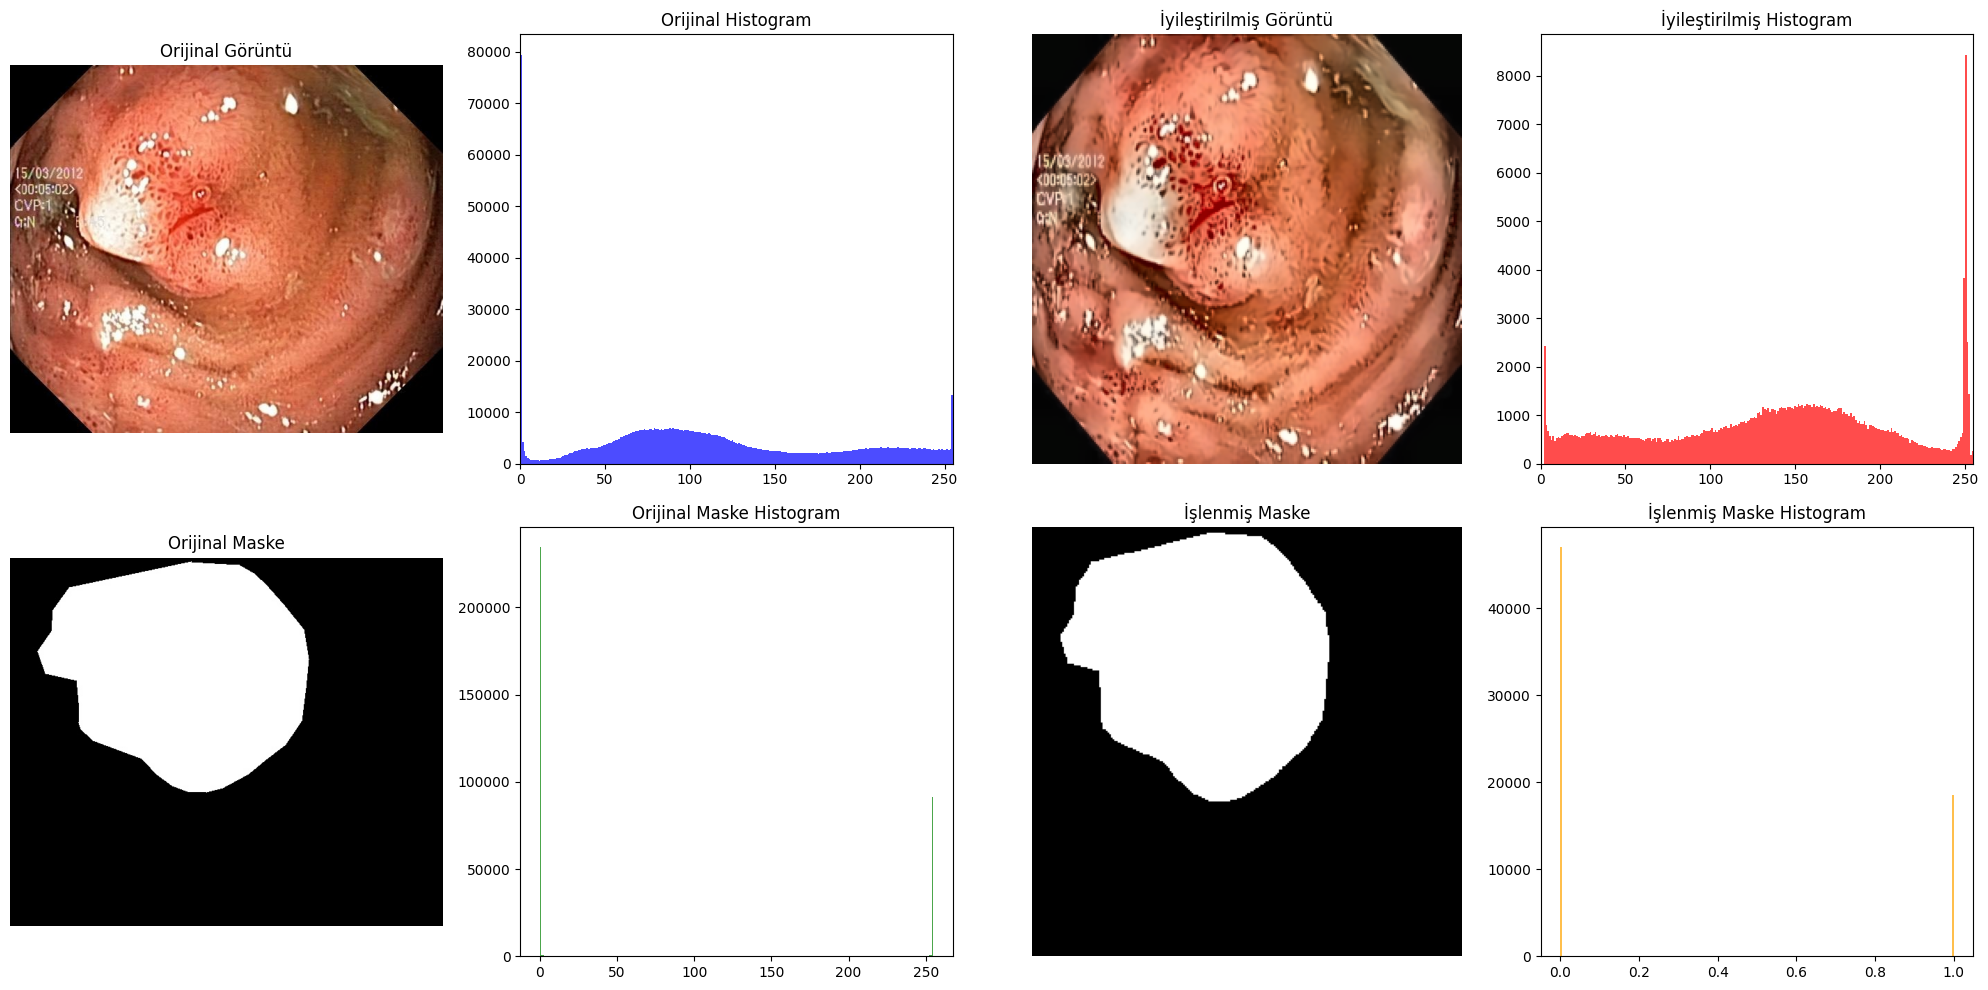

In [3]:
def load_and_preprocess_data_enhanced(images_dir, masks_dir, image_size=(256, 256), 
                                     apply_enhancement=True, apply_augmentation=False):
    """
    Gelişmiş ön işleme adımları
    """
    image_files = sorted(os.listdir(images_dir))
    mask_files = sorted(os.listdir(masks_dir))
    
    images = []
    masks = []
    
    print("🔄 Gelişmiş ön işleme ile görüntüler yükleniyor...")
    
    for i, (img_file, mask_file) in enumerate(zip(image_files, mask_files)):
        # Görüntü Yükleme
        img_path = os.path.join(images_dir, img_file)
        mask_path = os.path.join(masks_dir, mask_file)
        
        image = cv2.imread(img_path)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        
        if image is None or mask is None:
            print(f"⚠️  Hata: {img_file} veya {mask_file} yüklenemedi")
            continue
        
        # BGR'dan RGB'ye çevir
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        # Görüntü İyileştirme
        if apply_enhancement:
            # 1. CLAHE (Contrast Limited Adaptive Histogram Equalization)
            # Endoskopi görüntülerinde ışık dengesizliğini giderir
            lab = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)
            l, a, b = cv2.split(lab)
            
            clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
            l = clahe.apply(l)
            
            enhanced_lab = cv2.merge([l, a, b])
            image = cv2.cvtColor(enhanced_lab, cv2.COLOR_LAB2RGB)
            
            # 2. Gamma düzeltme (endoskopi için optimal: 0.8-1.2)
            gamma = 0.9
            image = np.power(image / 255.0, gamma) * 255.0
            image = np.clip(image, 0, 255).astype(np.uint8)
            
            # 3. Gürültü azaltma
            image = cv2.fastNlMeansDenoisingColored(
                image, 
                None, 
                h=10,
                hColor=10,
                templateWindowSize=7,
                searchWindowSize=21
            )
        
        # Mask İşleme
        # Adaptive thresholding
        if len(np.unique(mask)) > 2:  # Binary değilse
            # Otsu's thresholding
            _, mask = cv2.threshold(mask, 0, 255, 
                                   cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        
        # Morfolojik işlemler
        kernel = np.ones((3, 3), np.uint8)
        mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)  # Delikleri kapat
        mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)   # Gürültüyü temizle
        
        # Boyutlandırma
        image = cv2.resize(image, image_size, interpolation=cv2.INTER_AREA)
        mask = cv2.resize(mask, image_size, interpolation=cv2.INTER_NEAREST)
        
        # Normalizasyon
        # Görüntüyü normalize et
        image = image.astype(np.float32) / 255.0
        
        # Maskeyi binary yap
        mask = (mask > 128).astype(np.float32)
        
        # Data Augmentation
        if apply_augmentation and np.random.random() > 0.5:

            transform = A.Compose([
                A.HorizontalFlip(p=0.5),
                A.VerticalFlip(p=0.5),
                A.Rotate(limit=30, p=0.5),
                A.RandomBrightnessContrast(p=0.2),
            ])
            
            augmented = transform(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask']
        
        # Channel Dimension Ekleme 
        mask = np.expand_dims(mask, axis=-1)  # (H, W) -> (H, W, 1)
        
        images.append(image)
        masks.append(mask)
        
        # İlerlemeyi göster
        if (i + 1) % 200 == 0:
            print(f"   {i + 1}/{len(image_files)} görüntü işlendi...")
    
    print("✅ Tüm görüntüler gelişmiş ön işleme ile başarıyla işlendi!")
    return np.array(images), np.array(masks)

def visualize_preprocessing_comparison(original_img, enhanced_img, original_mask, processed_mask):
    """
    Ön işleme öncesi ve sonrasını karşılaştırmalı göster
    """
    import matplotlib.pyplot as plt
    
    fig, axes = plt.subplots(2, 4, figsize=(20, 10))
    
    # Orijinal görüntü
    axes[0, 0].imshow(original_img)
    axes[0, 0].set_title('Orijinal Görüntü')
    axes[0, 0].axis('off')
    
    # Orijinal görüntü histogramı
    axes[0, 1].hist(original_img.ravel(), bins=256, color='blue', alpha=0.7)
    axes[0, 1].set_title('Orijinal Histogram')
    axes[0, 1].set_xlim([0, 255])
    
    # İyileştirilmiş görüntü
    axes[0, 2].imshow(enhanced_img)
    axes[0, 2].set_title('İyileştirilmiş Görüntü')
    axes[0, 2].axis('off')
    
    # İyileştirilmiş histogram
    axes[0, 3].hist((enhanced_img * 255).ravel(), bins=256, color='red', alpha=0.7)
    axes[0, 3].set_title('İyileştirilmiş Histogram')
    axes[0, 3].set_xlim([0, 255])
    
    # Orijinal maske
    axes[1, 0].imshow(original_mask, cmap='gray')
    axes[1, 0].set_title('Orijinal Maske')
    axes[1, 0].axis('off')
    
    # Orijinal maske histogramı
    axes[1, 1].hist(original_mask.ravel(), bins=256, color='green', alpha=0.7)
    axes[1, 1].set_title('Orijinal Maske Histogram')
    
    # İşlenmiş maske
    axes[1, 2].imshow(processed_mask, cmap='gray')
    axes[1, 2].set_title('İşlenmiş Maske')
    axes[1, 2].axis('off')
    
    # İşlenmiş maske histogramı
    axes[1, 3].hist(processed_mask.ravel(), bins=256, color='orange', alpha=0.7)
    axes[1, 3].set_title('İşlenmiş Maske Histogram')
    
    plt.tight_layout()
    plt.show()

def analyze_dataset_statistics(images, masks):
    """
    Veri seti istatistiklerini analiz et
    """
    print("📊 VERİ SETİ İSTATİSTİKLERİ")
    print("=" * 50)
    
    # 1. Görüntü istatistikleri
    print("\n🔍 GÖRÜNTÜ İSTATİSTİKLERİ:")
    print(f"   Toplam görüntü sayısı: {len(images)}")
    print(f"   Görüntü boyutu: {images[0].shape}")
    print(f"   Piksel değer aralığı: [{images.min():.3f}, {images.max():.3f}]")
    print(f"   Ortalama parlaklık: {images.mean():.3f}")
    print(f"   Standart sapma: {images.std():.3f}")
    
    # 2. Maske istatistikleri
    print("\n🔍 MASKE İSTATİSTİKLERİ:")
    print(f"   Toplam maske sayısı: {len(masks)}")
    print(f"   Maske boyutu: {masks[0].shape}")
    
    # Polip/arkaplan oranı
    total_pixels = masks.size
    polyp_pixels = masks.sum()
    background_pixels = total_pixels - polyp_pixels
    
    print(f"   Toplam piksel sayısı: {total_pixels:,}")
    print(f"   Polip pikselleri: {polyp_pixels:,} (%{polyp_pixels/total_pixels*100:.2f})")
    print(f"   Arkaplan pikselleri: {background_pixels:,} (%{background_pixels/total_pixels*100:.2f})")
    
    # 3. Sınıf dengesizliği analizi
    print("\n⚖️  SINIF DENGESİZLİĞİ ANALİZİ:")
    class_ratio = background_pixels / (polyp_pixels + 1e-7)
    print(f"   Arkaplan/Polip oranı: {class_ratio:.2f}:1")
    
    if class_ratio > 10:
        print("   ⚠️  Yüksek sınıf dengesizliği tespit edildi!")
        print("   Öneri: Class weighting veya data augmentation uygulayın")
    
    # 4. Polip boyut analizi
    print("\n📏 POLİP BOYUT ANALİZİ:")
    polyp_sizes = []
    for mask in masks:
        polyp_size = mask.sum()
        if polyp_size > 0:
            polyp_sizes.append(polyp_size)
    
    if polyp_sizes:
        polyp_sizes = np.array(polyp_sizes)
        print(f"   Ortalama polip boyutu: {polyp_sizes.mean():.0f} piksel")
        print(f"   Minimum polip boyutu: {polyp_sizes.min():.0f} piksel")
        print(f"   Maksimum polip boyutu: {polyp_sizes.max():.0f} piksel")
        print(f"   Standart sapma: {polyp_sizes.std():.0f} piksel")
        
        # Boyut dağılımı
        small = (polyp_sizes < 100).sum()
        medium = ((polyp_sizes >= 100) & (polyp_sizes < 1000)).sum()
        large = (polyp_sizes >= 1000).sum()
        
        print(f"\n   Polip Boyut Dağılımı:")
        print(f"   Küçük (<100 px): {small} (%{small/len(polyp_sizes)*100:.1f})")
        print(f"   Orta (100-1000 px): {medium} (%{medium/len(polyp_sizes)*100:.1f})")
        print(f"   Büyük (≥1000 px): {large} (%{large/len(polyp_sizes)*100:.1f})")
    
    return {
        'total_images': len(images),
        'image_shape': images[0].shape,
        'pixel_range': (images.min(), images.max()),
        'mean_brightness': images.mean(),
        'std_brightness': images.std(),
        'polyp_ratio': polyp_pixels / total_pixels,
        'class_imbalance_ratio': class_ratio,
        'polyp_size_stats': {
            'mean': polyp_sizes.mean() if len(polyp_sizes) > 0 else 0,
            'min': polyp_sizes.min() if len(polyp_sizes) > 0 else 0,
            'max': polyp_sizes.max() if len(polyp_sizes) > 0 else 0,
            'std': polyp_sizes.std() if len(polyp_sizes) > 0 else 0
        }
    }

# KULLANIM ÖRNEĞİ:
if __name__ == "__main__":
    # Veriyi gelişmiş ön işleme ile yükle
    images_dir = "Kvasir-SEG/images/"
    masks_dir = "Kvasir-SEG/masks/"
    
    # Daha yüksek çözünürlükte yükle (256x256)
    images_enhanced, masks_enhanced = load_and_preprocess_data_enhanced(
        images_dir=images_dir,
        masks_dir=masks_dir,
        image_size=(256, 256),  # Çözünürlüğü artır
        apply_enhancement=True,   # Görüntü iyileştirme aktif
        apply_augmentation=False  # Eğitim sırasında augmentation yap
    )
    
    print(f"\n📊 Enhanced Images shape: {images_enhanced.shape}")
    print(f"📊 Enhanced Masks shape: {masks_enhanced.shape}")
    
    # İstatistikleri analiz et
    stats = analyze_dataset_statistics(images_enhanced, masks_enhanced)
    
    # Örnek görüntüleri karşılaştır
    sample_idx = 0
    original_img = cv2.imread(os.path.join(images_dir, sorted(os.listdir(images_dir))[sample_idx]))
    original_img = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)
    
    original_mask = cv2.imread(os.path.join(masks_dir, sorted(os.listdir(masks_dir))[sample_idx]), 
                               cv2.IMREAD_GRAYSCALE)
    
    visualize_preprocessing_comparison(
        original_img, 
        (images_enhanced[sample_idx] * 255).astype(np.uint8),
        original_mask,
        masks_enhanced[sample_idx].squeeze()
    )

## ADIM 4: VERİ SETİNİ BÖLME (TRAIN/VAL/TEST)

In [4]:
# Bölme İşlemi
print("📊 Veri seti bölünüyor...")

X_train, X_temp, y_train, y_temp = train_test_split(
    images_enhanced, masks_enhanced, test_size=0.3, random_state=42, shuffle=True
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, shuffle=True
)

# Boyut Kontrolü (Genişletme yapmıyoruz, sadece kontrol ediyoruz)
print("✅ Veri seti başarıyla bölündü!")
print(f"🎯 Eğitim seti: {X_train.shape[0]} görüntü")
print(f"🎯 Validation seti: {X_val.shape[0]} görüntü")
print(f"🎯 Test seti: {X_test.shape[0]} görüntü")

print("-" * 30)
print(f"📐 X_train shape: {X_train.shape}") # Beklenen: (N, 256, 256, 3)
print(f"📐 y_train shape: {y_train.shape}") # Beklenen: (N, 256, 256, 1)

# Eğer y_train shape (N, 256, 256) çıkarsa (sondaki 1 eksikse) o zaman genişletme gerekir.
if y_train.ndim == 3: # Eğer (N, H, W) ise
    print("⚠️ Boyut düzeltiliyor...")
    y_train = np.expand_dims(y_train, axis=-1)
    y_val = np.expand_dims(y_val, axis=-1)
    y_test = np.expand_dims(y_test, axis=-1)
    print(f"✅ Yeni y_train shape: {y_train.shape}")

📊 Veri seti bölünüyor...
✅ Veri seti başarıyla bölündü!
🎯 Eğitim seti: 700 görüntü
🎯 Validation seti: 150 görüntü
🎯 Test seti: 150 görüntü
------------------------------
📐 X_train shape: (700, 256, 256, 3)
📐 y_train shape: (700, 256, 256, 1)


## ADIM 5: U-NET MODEL MİMARİSİNİ OLUŞTURMA

In [5]:
def build_improved_unet_model(input_size=(256, 256, 3)):
    """
    Gelişmiş U-Net modeli
    """
    print("🧠 Gelişmiş U-Net model mimarisi oluşturuluyor...")
    
    inputs = Input(input_size)
    
    # --- ENCODER ---
    # 1. seviye
    c1 = Conv2D(32, 3, padding='same')(inputs)
    c1 = tf.keras.layers.BatchNormalization()(c1)
    c1 = tf.keras.layers.Activation('relu')(c1)
    c1 = Conv2D(32, 3, padding='same')(c1)
    c1 = tf.keras.layers.BatchNormalization()(c1)
    c1 = tf.keras.layers.Activation('relu')(c1)
    p1 = MaxPooling2D((2, 2))(c1)
    p1 = tf.keras.layers.Dropout(0.1)(p1)
    
    # 2. seviye
    c2 = Conv2D(64, 3, padding='same')(p1)
    c2 = tf.keras.layers.BatchNormalization()(c2)
    c2 = tf.keras.layers.Activation('relu')(c2)
    c2 = Conv2D(64, 3, padding='same')(c2)
    c2 = tf.keras.layers.BatchNormalization()(c2)
    c2 = tf.keras.layers.Activation('relu')(c2)
    p2 = MaxPooling2D((2, 2))(c2)
    p2 = tf.keras.layers.Dropout(0.1)(p2)
    
    # 3. seviye
    c3 = Conv2D(128, 3, padding='same')(p2)
    c3 = tf.keras.layers.BatchNormalization()(c3)
    c3 = tf.keras.layers.Activation('relu')(c3)
    c3 = Conv2D(128, 3, padding='same')(c3)
    c3 = tf.keras.layers.BatchNormalization()(c3)
    c3 = tf.keras.layers.Activation('relu')(c3)
    p3 = MaxPooling2D((2, 2))(c3)
    p3 = tf.keras.layers.Dropout(0.15)(p3)
    
    # 4. seviye
    c4 = Conv2D(256, 3, padding='same')(p3)
    c4 = tf.keras.layers.BatchNormalization()(c4)
    c4 = tf.keras.layers.Activation('relu')(c4)
    c4 = Conv2D(256, 3, padding='same')(c4)
    c4 = tf.keras.layers.BatchNormalization()(c4)
    c4 = tf.keras.layers.Activation('relu')(c4)
    p4 = MaxPooling2D((2, 2))(c4)
    p4 = tf.keras.layers.Dropout(0.15)(p4)
    
    # --- BOTTLENECK ---
    c5 = Conv2D(512, 3, padding='same')(p4)
    c5 = tf.keras.layers.BatchNormalization()(c5)
    c5 = tf.keras.layers.Activation('relu')(c5)
    c5 = Conv2D(512, 3, padding='same')(c5)
    c5 = tf.keras.layers.BatchNormalization()(c5)
    c5 = tf.keras.layers.Activation('relu')(c5)
    c5 = tf.keras.layers.Dropout(0.2)(c5)
    
    # --- DECODER ---
    # 4. seviye dekoder
    u6 = tf.keras.layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    u6 = tf.keras.layers.Dropout(0.15)(u6)
    c6 = Conv2D(256, 3, padding='same')(u6)
    c6 = tf.keras.layers.BatchNormalization()(c6)
    c6 = tf.keras.layers.Activation('relu')(c6)
    c6 = Conv2D(256, 3, padding='same')(c6)
    c6 = tf.keras.layers.BatchNormalization()(c6)
    c6 = tf.keras.layers.Activation('relu')(c6)
    
    # 3. seviye dekoder
    u7 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    u7 = tf.keras.layers.Dropout(0.15)(u7)
    c7 = Conv2D(128, 3, padding='same')(u7)
    c7 = tf.keras.layers.BatchNormalization()(c7)
    c7 = tf.keras.layers.Activation('relu')(c7)
    c7 = Conv2D(128, 3, padding='same')(c7)
    c7 = tf.keras.layers.BatchNormalization()(c7)
    c7 = tf.keras.layers.Activation('relu')(c7)
    
    # 2. seviye dekoder
    u8 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    u8 = tf.keras.layers.Dropout(0.1)(u8)
    c8 = Conv2D(64, 3, padding='same')(u8)
    c8 = tf.keras.layers.BatchNormalization()(c8)
    c8 = tf.keras.layers.Activation('relu')(c8)
    c8 = Conv2D(64, 3, padding='same')(c8)
    c8 = tf.keras.layers.BatchNormalization()(c8)
    c8 = tf.keras.layers.Activation('relu')(c8)
    
    # 1. seviye dekoder
    u9 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1])
    u9 = tf.keras.layers.Dropout(0.1)(u9)
    c9 = Conv2D(32, 3, padding='same')(u9)
    c9 = tf.keras.layers.BatchNormalization()(c9)
    c9 = tf.keras.layers.Activation('relu')(c9)
    c9 = Conv2D(32, 3, padding='same')(c9)  # Çıkıştan önceki son katman
    c9 = tf.keras.layers.BatchNormalization()(c9)
    c9 = tf.keras.layers.Activation('relu')(c9)
    
    # Çıkış katmanı
    outputs = Conv2D(1, 1, activation='sigmoid')(c9)
    
    model = Model(inputs=inputs, outputs=outputs)
    
    # Model özeti
    print("✅ Gelişmiş U-Net model mimarisi başarıyla oluşturuldu!")
    print(f"📊 Model katman sayısı: {len(model.layers)}")
    model.summary()
    
    return model

# Modeli oluşturma
model = build_improved_unet_model(input_size=(256, 256, 3))

🧠 Gelişmiş U-Net model mimarisi oluşturuluyor...
✅ Gelişmiş U-Net model mimarisi başarıyla oluşturuldu!
📊 Model katman sayısı: 77


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 256, 256, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d (Conv2D)               │ (None, 256, 256, 32)      │             896 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization           │ (None, 256, 256, 32)      │             128 │ conv2d[0][0]               │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation (Activation)       │ (None, 256, 256, 32)      │               0 │ batch_normalization[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_1 (Conv2D)             │ (None, 256, 256, 32)      │           9,248 │ activation[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_1         │ (None, 256, 256, 32)      │             128 │ conv2d_1[0][0]             │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation_1 (Activation)     │ (None, 256, 256, 32)      │               0 │ batch_normalization_1[0][… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d (MaxPooling2D)  │ (None, 128, 128, 32)      │               0 │ activation_1[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout (Dropout)             │ (None, 128, 128, 32)      │               0 │ max_pooling2d[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_2 (Conv2D)             │ (None, 128, 128, 64)      │          18,496 │ dropout[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_2         │ (None, 128, 128, 64)      │             256 │ conv2d_2[0][0]             │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation_2 (Activation)     │ (None, 128, 128, 64)      │               0 │ batch_normalization_2[0][… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_3 (Conv2D)             │ (None, 128, 128, 64)      │          36,928 │ activation_2[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_3         │ (None, 128, 128, 64)      │             256 │ conv2d_3[0][0]             │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation_3 (Activation)     │ (None, 128, 128, 64)      │               0 │ batch_normalization_3[0][… │
├───────────────────────────────┼───────────────────────────┼───────────────

 Total params: 7,771,873 (29.65 MB)

 Trainable params: 7,765,985 (29.62 MB)

 Non-trainable params: 5,888 (23.00 KB)

## ADIM 6: MODELİ DERLEME (COMPILE)

In [6]:
# 1. METRİK: Dice Coefficient (Eğitim sırasında gidişatı görmek için)
def dice_coef(y_true, y_pred, smooth=1e-6):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

# 2. LOSS: Dice Loss (Modelin doğru öğrenmesi için ZORUNLU)
# Sınıf dengesizliğini çözmek için eğitimde bunu kullanıyoruz.
def dice_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)

print("⚙️ Model derleniyor...")

model.compile(
    optimizer=Adam(learning_rate=1e-4), 
    loss=dice_loss,                   # Eğitim için Dice Loss seçildi
    metrics=['accuracy', dice_coef]   # Sadece temel metrikleri takip ediyoruz
)

print("✅ Model başarıyla derlendi!")
print("   • Loss: Dice Loss (Sınıf dengesizliği için)")
print("   • Takip: Accuracy, Dice Coeff")

⚙️ Model derleniyor...
✅ Model başarıyla derlendi!
   • Loss: Dice Loss (Sınıf dengesizliği için)
   • Takip: Accuracy, Dice Coeff


## ADIM 7: CALLBACK'LERİ TANIMLAMA

In [7]:
# Eğitim sırasında kullanılacak callback'leri tanımla
print("🔄 Callback'ler tanımlanıyor...")

callbacks = [
    # En iyi modeli kaydet
    ModelCheckpoint(
        filepath='best_model.keras',
        monitor='val_dice_coef',
        save_best_only=True,
        save_weights_only=False,
        mode='max',
        verbose=1
    ),
    
    # Erken durdurma
    EarlyStopping(
        monitor='val_dice_coef', # Dice skoru iyileşmezse dur
        patience=15,             # 15 tur sabret
        restore_best_weights=True,
        mode='max',              # Skorun artmasını bekle
        verbose=1
    ),
    
    # Öğrenme oranını ayarla
    ReduceLROnPlateau(
        monitor='val_dice_coef', # Dice skoru takılırsa
        factor=0.5,              # Hızı yarıya düşür
        patience=5,              # 5 tur bekle
        min_lr=1e-6,
        mode='max',              # Skorun artmasını bekle
        verbose=1
    )
]

print("✅ Callback'ler başarıyla tanımlandı!")

🔄 Callback'ler tanımlanıyor...
✅ Callback'ler başarıyla tanımlandı!


## ADIM 8: MODEL EĞİTİMİ

In [8]:
# Model eğitimi
print("🚀 Model eğitimi başlıyor...")
print(f"🎯 Eğitim Seti: {X_train.shape} - {y_train.shape}")
print(f"🎯 Doğrulama Seti: {X_val.shape} - {y_val.shape}")
print("⏰ Bu işlem donanımına göre zaman alabilir, lütfen bekleyin...")

start_time = time.time()

# Eğitim geçmişini kaydet
history = model.fit(
    X_train, y_train,          
    batch_size=8,             
    epochs=50,
    validation_data=(X_val, y_val), 
    callbacks=callbacks,
    verbose=1,
    shuffle=True            # Her epoch'ta veriyi karıştır
)

end_time = time.time()
training_duration = (end_time - start_time) / 60

print(f"✅ Model eğitimi tamamlandı!")
print(f"⏱️ Toplam eğitim süresi: {training_duration:.2f} dakika")

🚀 Model eğitimi başlıyor...
🎯 Eğitim Seti: (700, 256, 256, 3) - (700, 256, 256, 1)
🎯 Doğrulama Seti: (150, 256, 256, 3) - (150, 256, 256, 1)
⏰ Bu işlem donanımına göre zaman alabilir, lütfen bekleyin...
Epoch 1/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.6893 - dice_coef: 0.3252 - loss: 0.6748
Epoch 1: val_dice_coef improved from None to 0.20879, saving model to best_model.keras
88/88 ━━━━━━━━━━━━━━━━━━━━ 421s 5s/step - accuracy: 0.7059 - dice_coef: 0.3749 - loss: 0.6248 - val_accuracy: 0.8438 - val_dice_coef: 0.2088 - val_loss: 0.7913 - learning_rate: 1.0000e-04
Epoch 2/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.7822 - dice_coef: 0.4653 - loss: 0.5347
Epoch 2: val_dice_coef did not improve from 0.20879
88/88 ━━━━━━━━━━━━━━━━━━━━ 427s 5s/step - accuracy: 0.7837 - dice_coef: 0.4643 - loss: 0.5368 - val_accuracy: 0.8438 - val_dice_coef: 0.1318 - val_loss: 0.8682 - learning_rate: 1.0000e-04
Epoch 3/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.8028 - dice_c

## ADIM 9: EĞİTİM GEÇMİŞİNİ GÖRSELLEŞTİRME

📈 Eğitim geçmişi detaylı görselleştiriliyor...


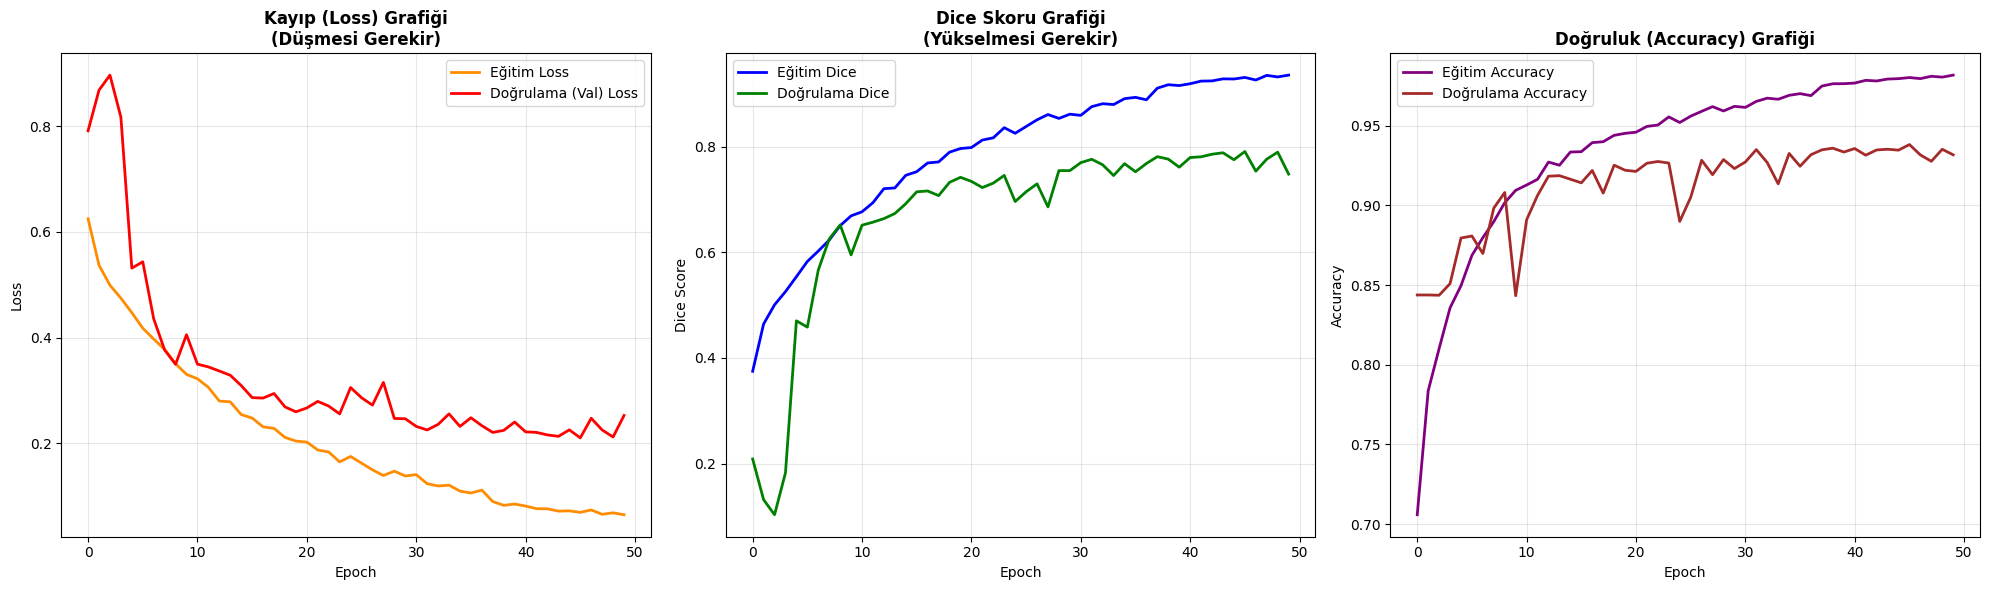

✅ Tüm metriklerin grafikleri kaydedildi!


In [9]:
# Eğitim geçmişini görselleştirme
print("📈 Eğitim geçmişi detaylı görselleştiriliyor...")

# Grafik boyutunu ayarlayalım (3 yan yana grafik için genişlik artırıldı)
plt.figure(figsize=(20, 6))

# 1. GRAFİK: LOSS (Kayıp)
plt.subplot(1, 3, 1)
plt.plot(history.history['loss'], label='Eğitim Loss', linewidth=2, color='darkorange')
plt.plot(history.history['val_loss'], label='Doğrulama (Val) Loss', linewidth=2, color='red')
plt.title('Kayıp (Loss) Grafiği\n(Düşmesi Gerekir)', fontsize=12, fontweight='bold')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.grid(True, alpha=0.3)

# 2. GRAFİK: DICE COEFFICIENT (Başarı) 
plt.subplot(1, 3, 2)
# Not: Eğer hata alırsanız history anahtarlarını kontrol edin (örn: 'dice_coef_fn' olabilir)
plt.plot(history.history['dice_coef'], label='Eğitim Dice', linewidth=2, color='blue')
plt.plot(history.history['val_dice_coef'], label='Doğrulama Dice', linewidth=2, color='green')
plt.title('Dice Skoru Grafiği\n(Yükselmesi Gerekir)', fontsize=12, fontweight='bold')
plt.ylabel('Dice Score')
plt.xlabel('Epoch')
plt.legend()
plt.grid(True, alpha=0.3)

# 3. GRAFİK: ACCURACY (Doğruluk)
plt.subplot(1, 3, 3)
plt.plot(history.history['accuracy'], label='Eğitim Accuracy', linewidth=2, color='purple')
plt.plot(history.history['val_accuracy'], label='Doğrulama Accuracy', linewidth=2, color='brown')
plt.title('Doğruluk (Accuracy) Grafiği', fontsize=12, fontweight='bold')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('egitim_sonuclari_tum_metrikler.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Tüm metriklerin grafikleri kaydedildi!")

## ADIM 10: MODEL DEĞERLENDİRME VE METRİK HESAPLAMA

In [10]:
# Segmentasyon metriklerini hesaplama fonksiyonu
def calculate_segmentation_metrics(y_true, y_pred):
    """
    - Dice Katsayısı
    - IoU (Intersection over Union)
    - Sensitivity
    - Specificity
    - Accuracy
    """

    y_true = y_true.squeeze()
    y_pred = y_pred.squeeze()
    
    # Binary threshold uygula
    y_pred_binary = (y_pred > 0.5).astype(np.float32)
    y_true_binary = y_true.astype(np.float32)
    
    # True Positive, False Positive, True Negative, False Negative
    tp = np.sum(y_true_binary * y_pred_binary)
    fp = np.sum(y_pred_binary * (1 - y_true_binary))
    tn = np.sum((1 - y_true_binary) * (1 - y_pred_binary))
    fn = np.sum(y_true_binary * (1 - y_pred_binary))
    
  # Intersection and Union
    intersection = tp
    union = tp + fp + fn
    smooth = 1e-6
    
    # Metrikleri hesapla
    iou = intersection / (union + smooth)
    dice = (2. * tp) / (2 * tp + fp + fn + smooth)
    sensitivity = tp / (tp + fn + smooth)
    specificity = tn / (tn + fp + smooth)
    precision = tp / (tp + fp + smooth)
    accuracy = (tp + tn) / (tp + tn + fp + fn + smooth)
    
    return {
        'IoU': iou,
        'Dice': dice,
        'Sensitivity': sensitivity,
        'Specificity': specificity,
        'Precision': precision,
        'Accuracy': accuracy
    }

# Test seti üzerinde tahmin yap
print("🧪 Test seti üzerinde tahmin yapılıyor...")
test_predictions = model.predict(X_test, verbose=1)

# Tüm test görüntüleri için metrikleri hesapla
print("📊 Metrikler hesaplanıyor...")
all_metrics = []

for i in range(len(X_test)):
    metrics = calculate_segmentation_metrics(y_test[i], test_predictions[i].squeeze())
    all_metrics.append(metrics)

# Ortalama metrikleri hesapla
mean_metrics = {}
for key in all_metrics[0].keys():
    mean_metrics[key] = np.mean([m[key] for m in all_metrics])

print("✅ Metrikler başarıyla hesaplandı!")

🧪 Test seti üzerinde tahmin yapılıyor...
5/5 ━━━━━━━━━━━━━━━━━━━━ 15s 3s/step
📊 Metrikler hesaplanıyor...
✅ Metrikler başarıyla hesaplandı!


## ADIM 11: PERFORMANS METRİKLERİNİ RAPORLAMA

In [11]:
# İstenilen metrikleri raporla
print("\n" + "="*80)
print("🎯 MEDİKAL GÖRÜNTÜ SEGMENTASYONU - PERFORMANS RAPORU")
print("="*80)
print("📋 PROJE BİLGİLERİ:")
print(f"   • Veri Seti: Kvasir-SEG Gastrointestinal Lezyonlar")
print(f"   • Görüntü Sayısı: 1000 (700 eğitim, 150 validation, 150 test)")
print(f"   • Görüntü Boyutu: 256x256 piksel")
print(f"   • Model: U-Net (Derin Öğrenme)")
print(f"   • Görev: Gastrointestinal lezyon segmentasyonu")

print("\n📊 METRİKLER:")
print("-" * 50)
print(f"   ✅ Dice Katsayısı:          {mean_metrics['Dice']:.4f}")
print(f"   ✅ IoU (Intersection over Union): {mean_metrics['IoU']:.4f}")
print(f"   ✅ Sensitivity:             {mean_metrics['Sensitivity']:.4f}")
print(f"   ✅ Specificity:             {mean_metrics['Specificity']:.4f}")

print("\n📈 EK PERFORMANS METRİKLERİ:")
print("-" * 50)
print(f"   📊 Precision:               {mean_metrics['Precision']:.4f}")
print(f"   📊 Accuracy:                {mean_metrics['Accuracy']:.4f}")

print("\n📝 METRİK AÇIKLAMALARI:")
print("-" * 50)
print("   • Dice: Benzerlik katsayısı (0-1 arası, 1 en iyi)")
print("   • IoU: Kesişim alanının birleşim alanına oranı")
print("   • Sensitivity: Gerçek pozitifleri (Polip) doğru tespit etme oranı")
print("   • Specificity: Gerçek negatifleri (Arkaplan) doğru ayırt etme oranı")
print("   • Accuracy: Toplam piksel bazında genel doğruluk oranı")
print("="*80)


🎯 MEDİKAL GÖRÜNTÜ SEGMENTASYONU - PERFORMANS RAPORU
📋 PROJE BİLGİLERİ:
   • Veri Seti: Kvasir-SEG Gastrointestinal Lezyonlar
   • Görüntü Sayısı: 1000 (700 eğitim, 150 validation, 150 test)
   • Görüntü Boyutu: 256x256 piksel
   • Model: U-Net (Derin Öğrenme)
   • Görev: Gastrointestinal lezyon segmentasyonu

📊 METRİKLER:
--------------------------------------------------
   ✅ Dice Katsayısı:          0.7770
   ✅ IoU (Intersection over Union): 0.6874
   ✅ Sensitivity:             0.7914
   ✅ Specificity:             0.9739

📈 EK PERFORMANS METRİKLERİ:
--------------------------------------------------
   📊 Precision:               0.8185
   📊 Accuracy:                0.9389

📝 METRİK AÇIKLAMALARI:
--------------------------------------------------
   • Dice: Benzerlik katsayısı (0-1 arası, 1 en iyi)
   • IoU: Kesişim alanının birleşim alanına oranı
   • Sensitivity: Gerçek pozitifleri (Polip) doğru tespit etme oranı
   • Specificity: Gerçek negatifleri (Arkaplan) doğru ayırt etme oran

## ADIM 12: DETAYLI METRİK ANALİZİ


📋 METRİKLERİN İSTATİSTİKSEL ÖZETİ:
              IoU        Dice  Sensitivity  Specificity   Precision  \
count  150.000000  150.000000   150.000000   150.000000  150.000000   
mean     0.687382    0.776962     0.791429     0.973870    0.818520   
std      0.260356    0.251444     0.272504     0.048888    0.258485   
min      0.000000    0.000000     0.000000     0.681492    0.000000   
25%      0.601614    0.751256     0.746141     0.976697    0.771469   
50%      0.768206    0.868910     0.916525     0.991888    0.933312   
75%      0.887951    0.940650     0.973367     0.997750    0.979745   
max      0.970912    0.985241     1.000000     1.000000    1.000000   

         Accuracy  
count  150.000000  
mean     0.938892  
std      0.077903  
min      0.510406  
25%      0.928314  
50%      0.971588  
75%      0.989380  
max      0.998703  
------------------------------------------------------------

📈 Rapor için en önemli 4 grafik oluşturuluyor...


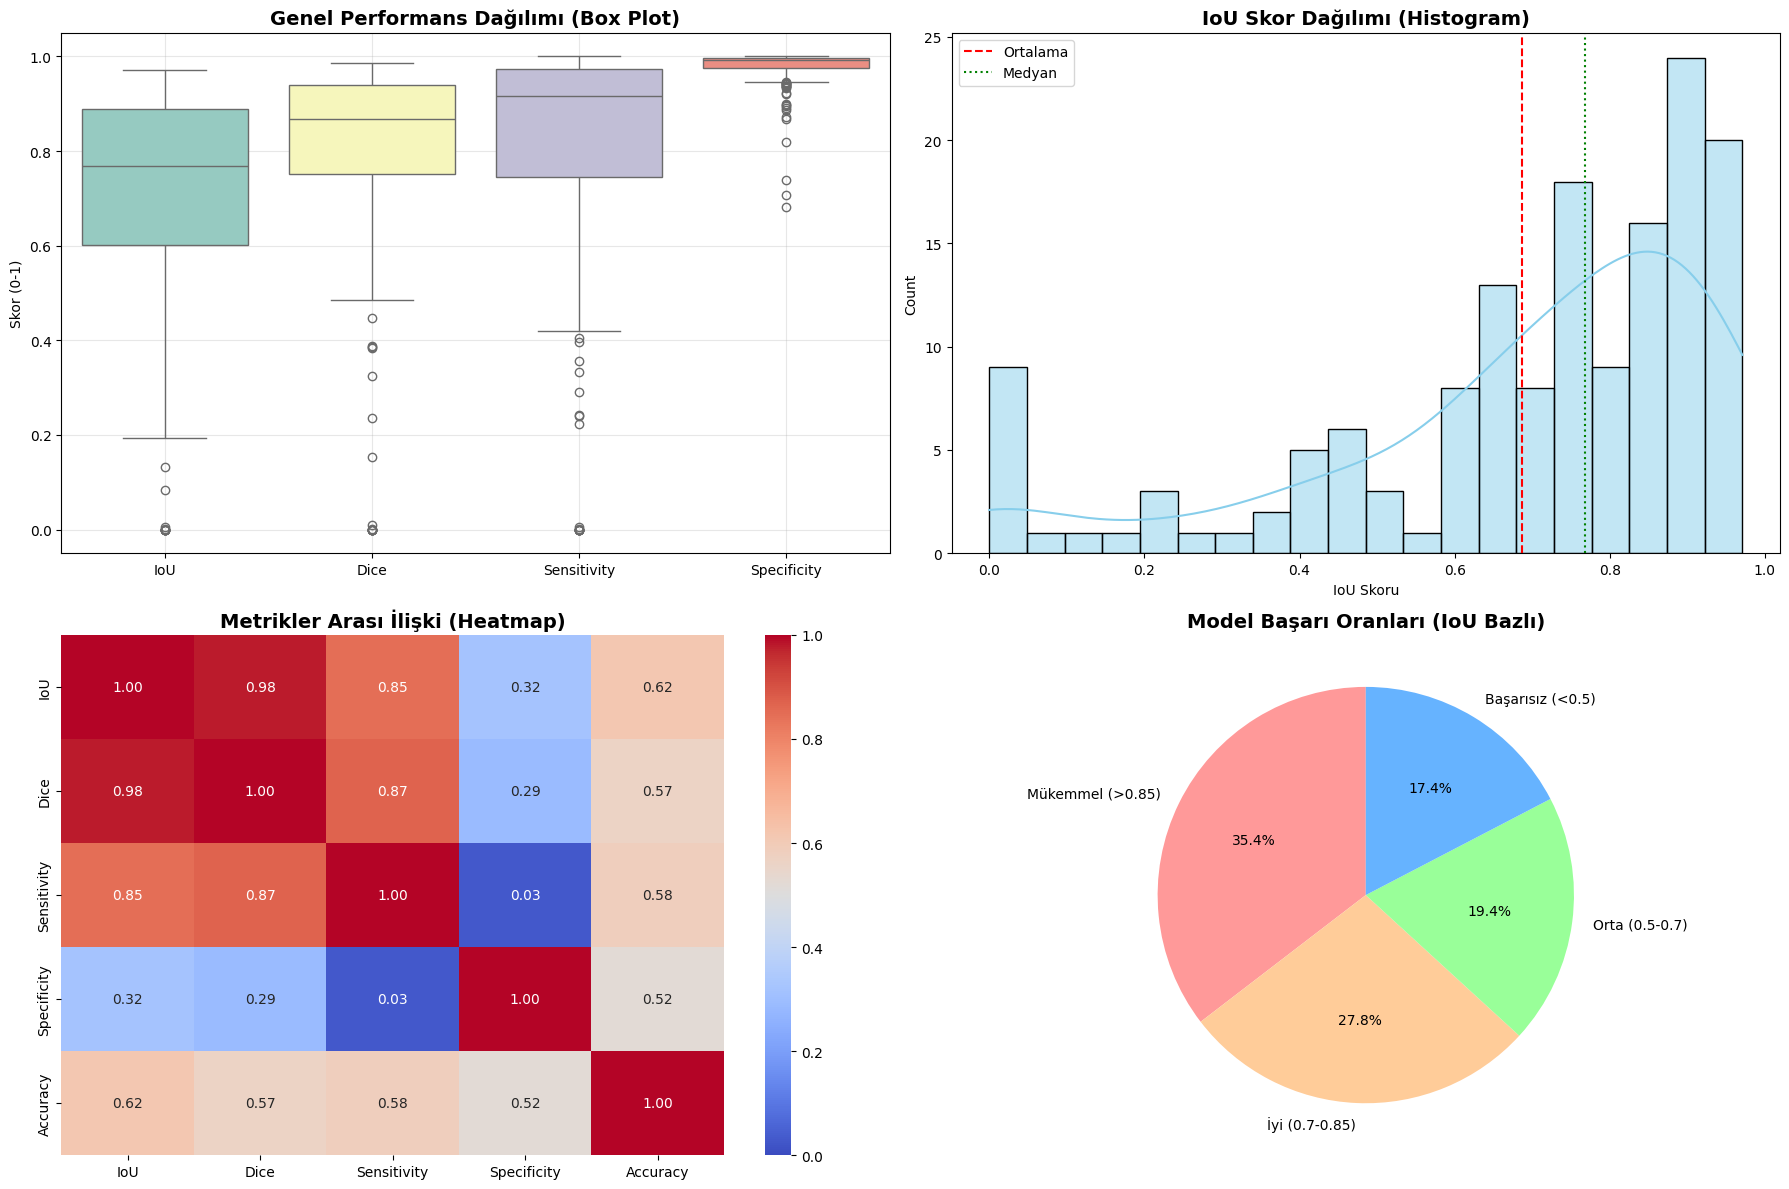

In [13]:
# Veri kontrolü
if 'all_metrics' in locals():
    metrics_df = pd.DataFrame(all_metrics)
else:
    print("⚠️ Hata: 'all_metrics' bulunamadı. Lütfen önce ADIM 10 veya 11'i çalıştırın.")

print("\n📋 METRİKLERİN İSTATİSTİKSEL ÖZETİ:")
summary_stats = metrics_df.describe()
print(summary_stats)
print("-" * 60)

# GÖRSELLEŞTİRMELER
print("\n📈 Rapor için en önemli 4 grafik oluşturuluyor...")

plt.figure(figsize=(18, 12))

# GRAFİK 1: Box Plot (Genel Dağılım)
plt.subplot(2, 2, 1)
metrics_to_plot = ['IoU', 'Dice', 'Sensitivity', 'Specificity']
sns.boxplot(data=metrics_df[metrics_to_plot], palette="Set3")
plt.title('Genel Performans Dağılımı (Box Plot)', fontsize=14, fontweight='bold')
plt.ylabel('Skor (0-1)')
plt.grid(True, alpha=0.3)

# GRAFİK 2: IoU Histogramı (Detaylı Başarım)
plt.subplot(2, 2, 2)
sns.histplot(metrics_df['IoU'], bins=20, kde=True, color='skyblue')
plt.axvline(metrics_df['IoU'].mean(), color='red', linestyle='--', label='Ortalama')
plt.axvline(metrics_df['IoU'].median(), color='green', linestyle=':', label='Medyan')
plt.title('IoU Skor Dağılımı (Histogram)', fontsize=14, fontweight='bold')
plt.xlabel('IoU Skoru')
plt.legend()

# GRAFİK 3: Korelasyon Matrisi (İlişkiler)
plt.subplot(2, 2, 3)
sns.heatmap(metrics_df[['IoU', 'Dice', 'Sensitivity', 'Specificity', 'Accuracy']].corr(), 
            annot=True, cmap='coolwarm', fmt=".2f", vmin=0, vmax=1)
plt.title('Metrikler Arası İlişki (Heatmap)', fontsize=14, fontweight='bold')

# GRAFİK 4: Başarı Kategorileri (Pasta Grafiği)
plt.subplot(2, 2, 4)
categories = pd.cut(metrics_df['IoU'], 
                    bins=[0, 0.5, 0.7, 0.85, 1.0],
                    labels=['Başarısız (<0.5)', 'Orta (0.5-0.7)', 'İyi (0.7-0.85)', 'Mükemmel (>0.85)'])
counts = categories.value_counts()
colors = ['#ff9999', '#ffcc99', '#99ff99', '#66b3ff'] # Pastel renkler
plt.pie(counts, labels=counts.index, autopct='%1.1f%%', colors=colors, startangle=90)
plt.title('Model Başarı Oranları (IoU Bazlı)', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig('final_rapor_grafikleri.png', dpi=300)
plt.show()

## ADIM 13: GÖRSELLEŞTİRME - BAŞARILI VE BAŞARISIZ ÖRNEKLER

🎨 Sonuçlar görselleştiriliyor...

🏆 EN BAŞARILI 4 SONUÇ (Yüksek IoU):


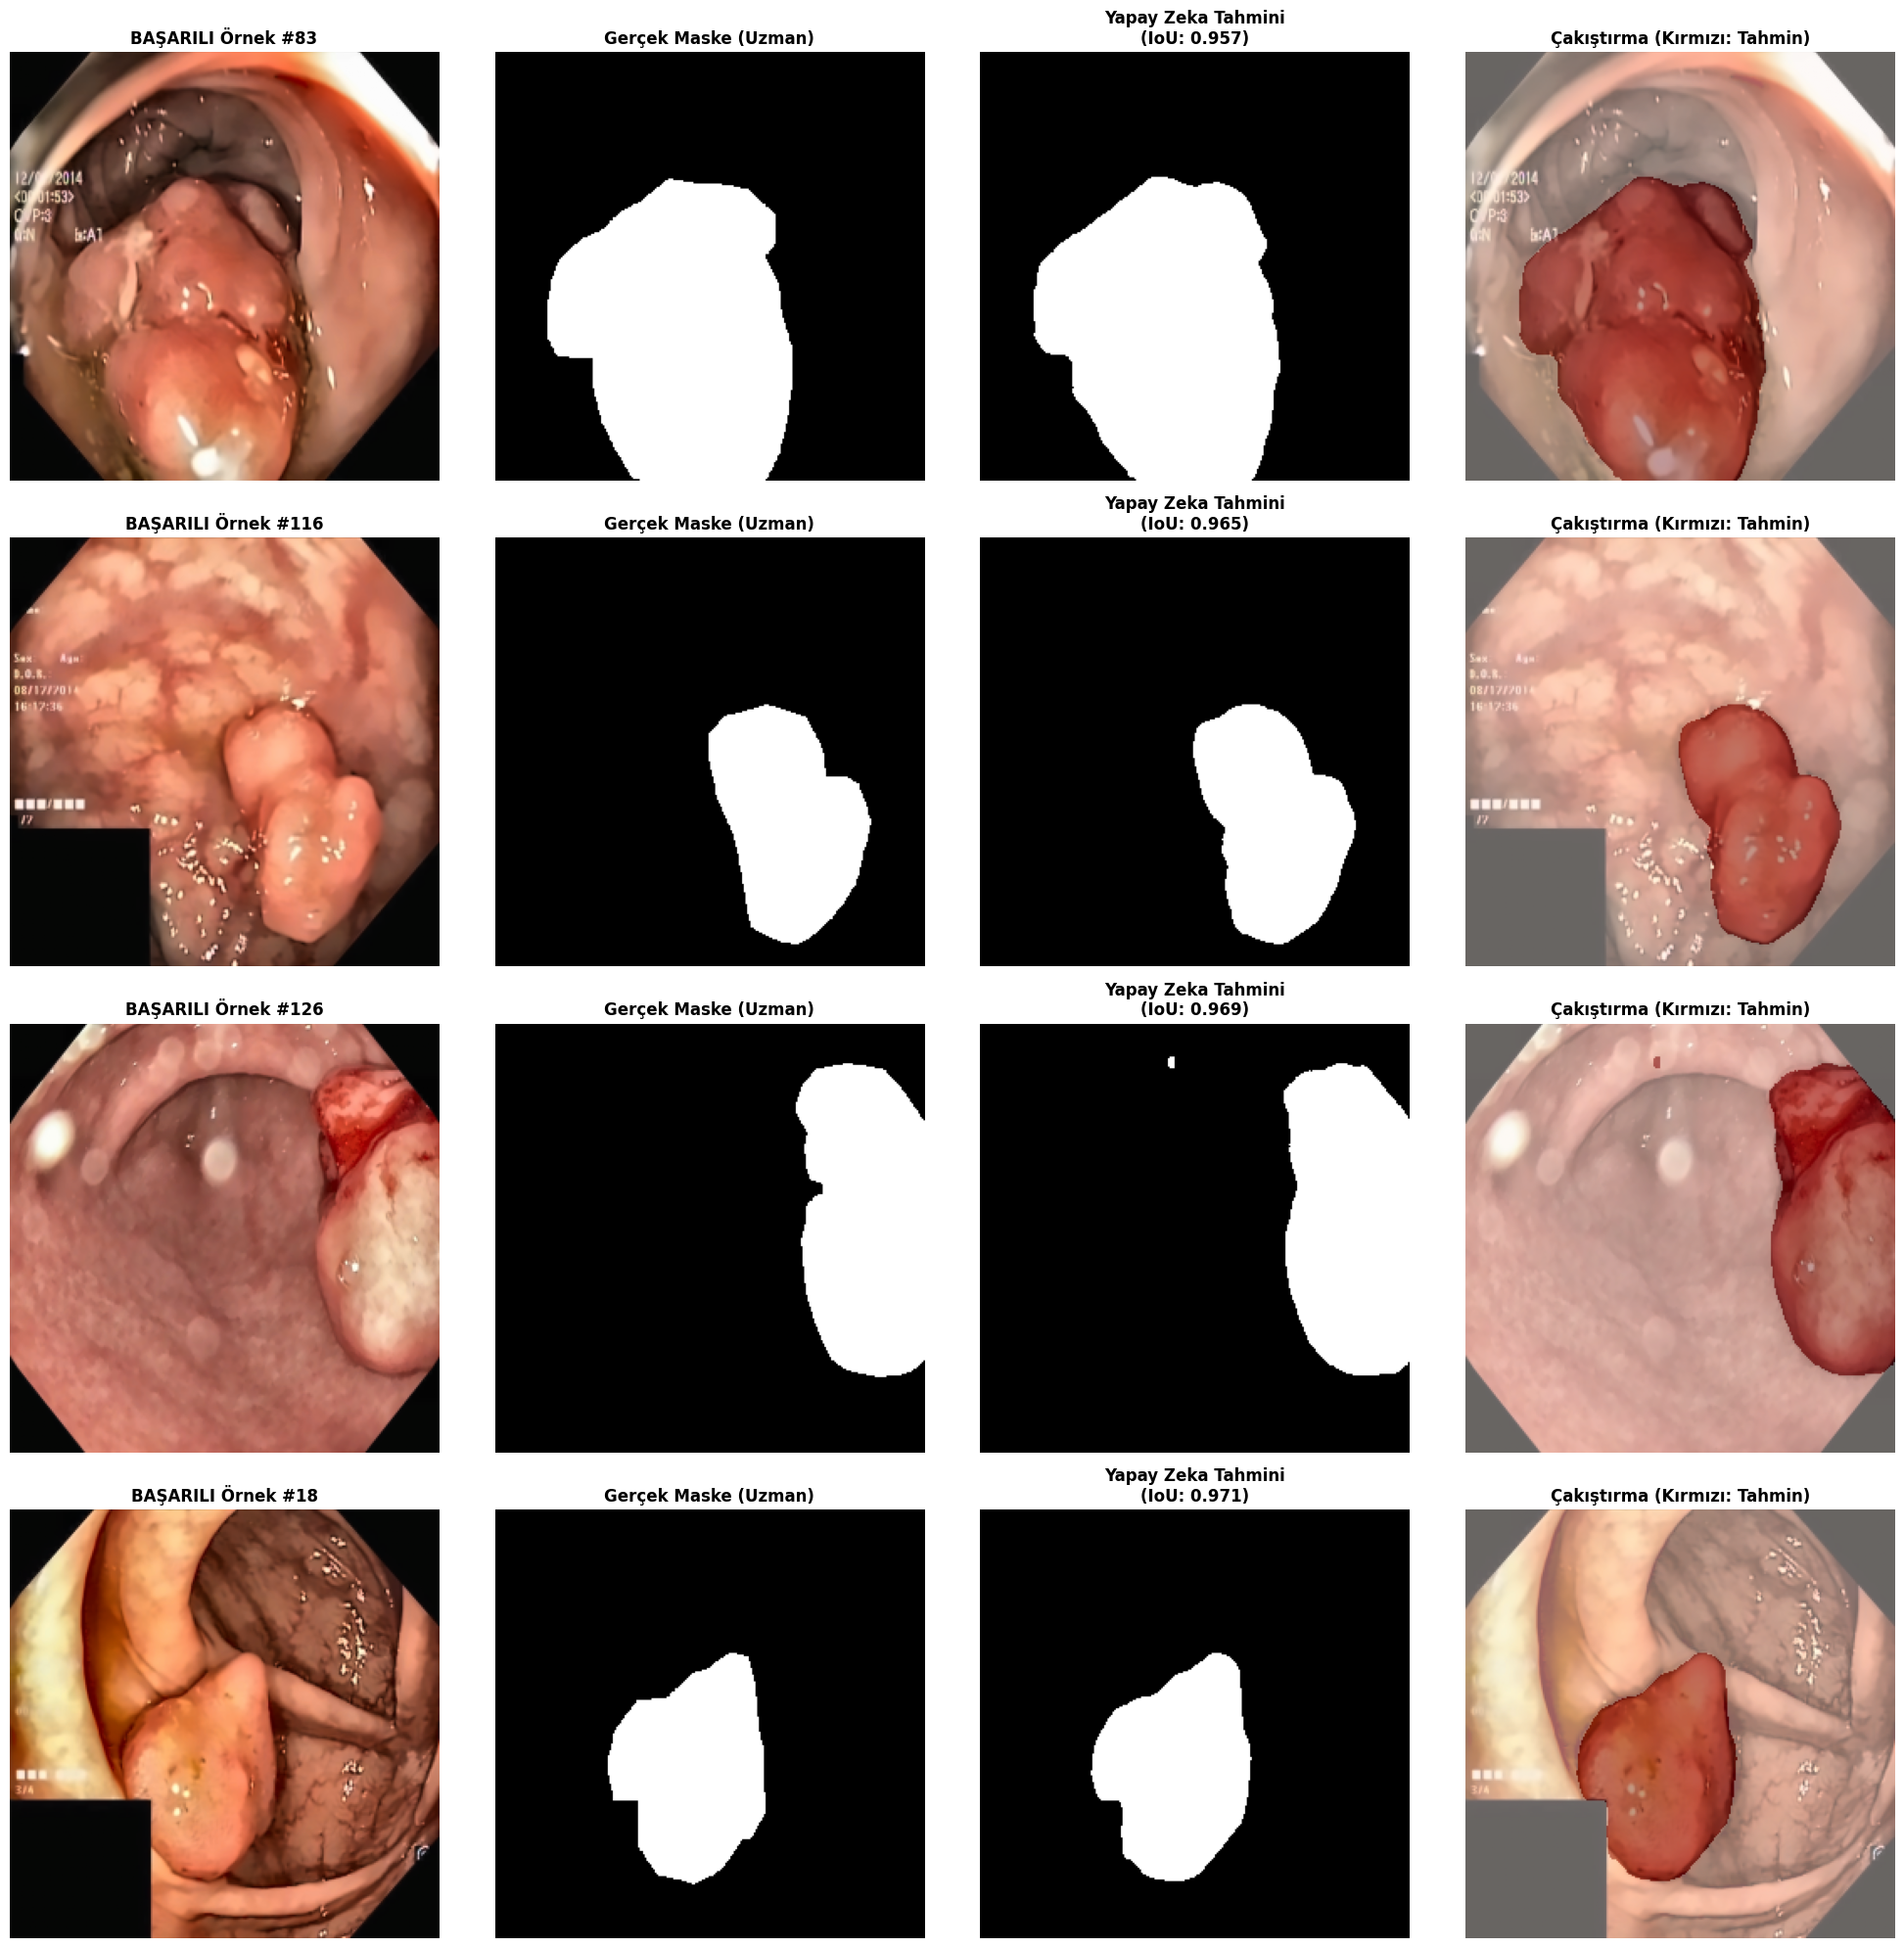


⚠️ EN BAŞARISIZ 4 SONUÇ (Düşük IoU):


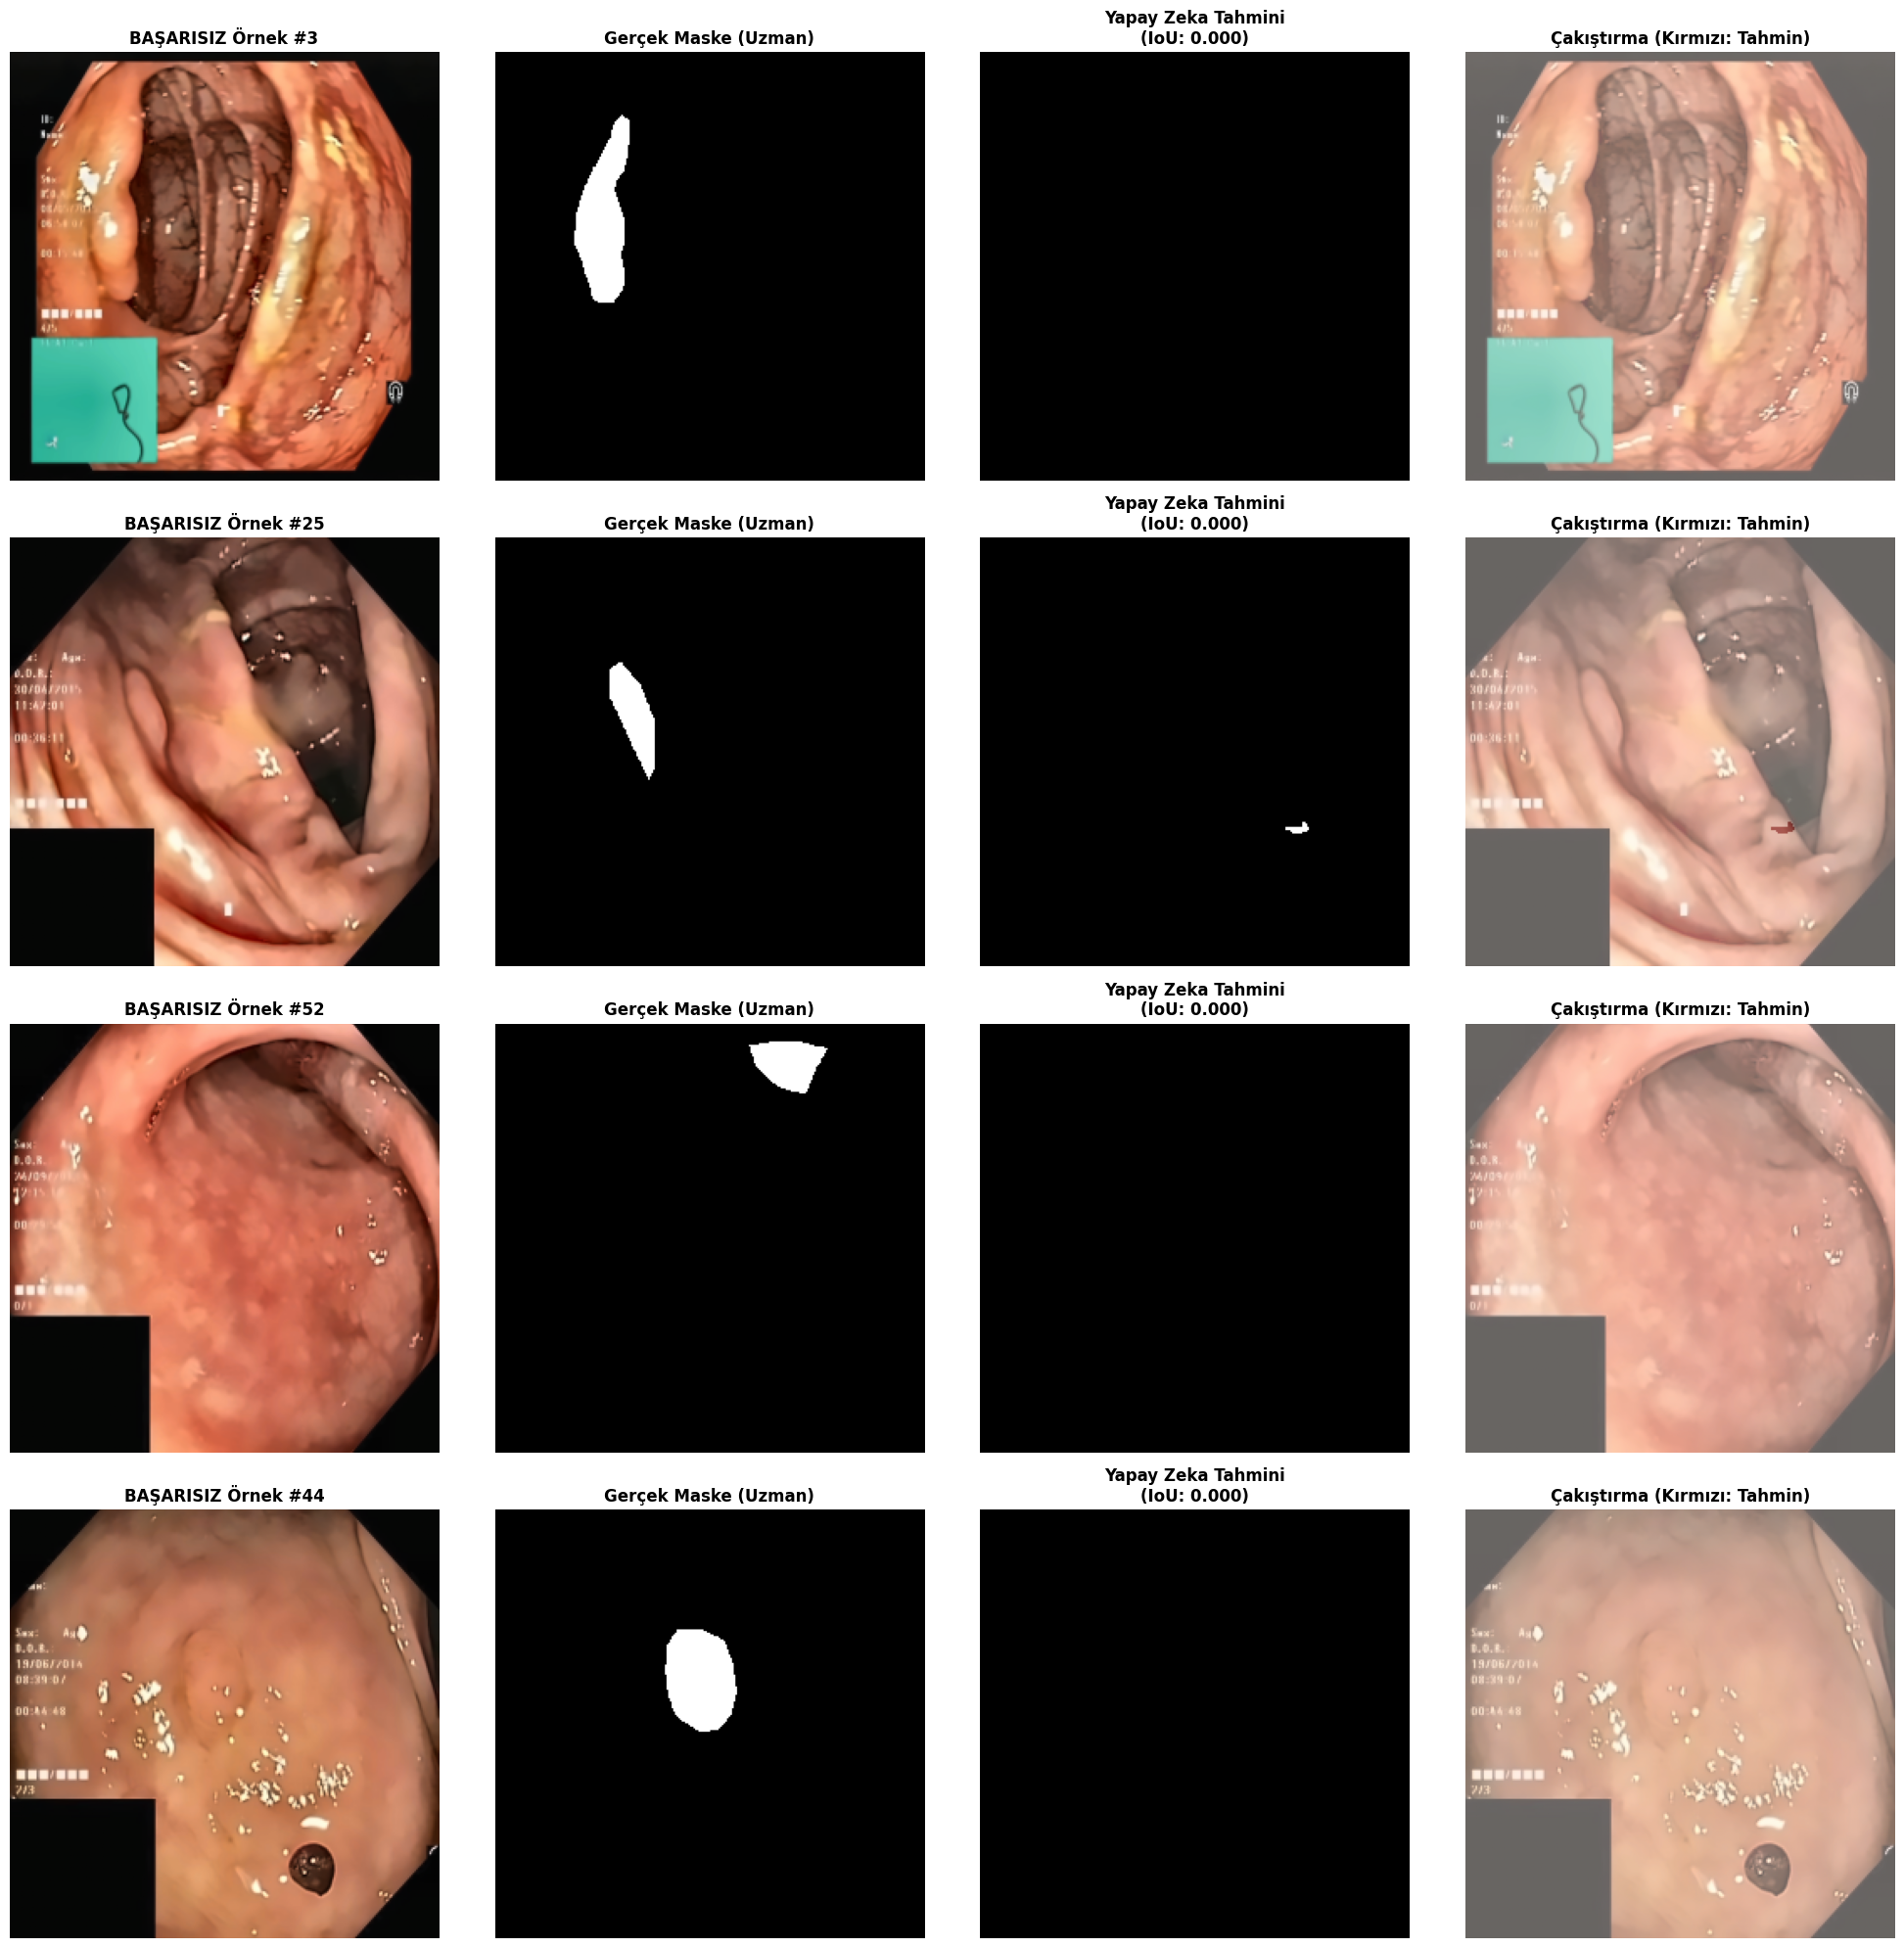

In [14]:
# En iyi ve en kötü sonuçları görselleştirme
print("🎨 Sonuçlar görselleştiriliyor...")

# Eğer all_metrics listesi yoksa hata vermemesi için kontrol
if 'all_metrics' in locals():
    # En iyi ve en kötü IoU değerlerine sahip örnekleri bul
    iou_scores = [m['IoU'] for m in all_metrics]
    best_indices = np.argsort(iou_scores)[-4:]  # En yüksek IoU'ya sahip 4 örnek
    worst_indices = np.argsort(iou_scores)[:4]  # En düşük IoU'ya sahip 4 örnek

    def visualize_comparison(indices, title):
        # Grafik alanını oluştur
        fig, axes = plt.subplots(len(indices), 4, figsize=(20, 5*len(indices)))
        
        # Tek satır varsa diziye çevir (Hata önleyici)
        if len(indices) == 1:
            axes = [axes]
        
        for i, idx in enumerate(indices):
            # 1. Orijinal Görüntü
            axes[i][0].imshow(X_test[idx])
            axes[i][0].set_title(f'{title} Örnek #{idx+1}', fontweight='bold')
            axes[i][0].axis('off')
            
            # 2. Gerçek Maske (Ground Truth)
            # squeeze() ile (256, 256, 1) -> (256, 256) yapıyoruz
            axes[i][1].imshow(y_test[idx].squeeze(), cmap='gray')
            axes[i][1].set_title('Gerçek Maske (Uzman)', fontweight='bold')
            axes[i][1].axis('off')
            
            # 3. Tahmin Edilen Maske
            pred = (test_predictions[idx] > 0.5).astype(np.float32)
            axes[i][2].imshow(pred.squeeze(), cmap='gray')
            axes[i][2].set_title(f'Yapay Zeka Tahmini\n(IoU: {iou_scores[idx]:.3f})', fontweight='bold')
            axes[i][2].axis('off')
            
            # 4. Çakıştırma (Overlay)
            axes[i][3].imshow(X_test[idx])
            # Kırmızı renk ile maskeyi bindir
            axes[i][3].imshow(pred.squeeze(), alpha=0.4, cmap='Reds')
            axes[i][3].set_title('Çakıştırma (Kırmızı: Tahmin)', fontweight='bold')
            axes[i][3].axis('off')
        
        plt.tight_layout()
        plt.show()

    print("\n🏆 EN BAŞARILI 4 SONUÇ (Yüksek IoU):")
    visualize_comparison(best_indices, "BAŞARILI")

    print("\n⚠️ EN BAŞARISIZ 4 SONUÇ (Düşük IoU):")
    visualize_comparison(worst_indices, "BAŞARISIZ")

else:
    print("⚠️ Hata: 'all_metrics' değişkeni bulunamadı. Lütfen ADIM 10'u çalıştırın.")

## ADIM 14: SONUÇLARI KAYDETME VE RAPOR HAZIRLAMA

In [15]:
print("💾 Proje sonuçları kaydediliyor...")

# JSON serializable hale getirme fonksiyonu
def convert_numpy_types(obj):
    """NumPy tiplerini Python native tiplerine dönüştür"""
    if isinstance(obj, (np.float32, np.float64)):
        return float(obj)
    elif isinstance(obj, (np.int32, np.int64)):
        return int(obj)
    elif isinstance(obj, np.ndarray):
        return obj.tolist()
    elif isinstance(obj, dict):
        return {key: convert_numpy_types(value) for key, value in obj.items()}
    elif isinstance(obj, list):
        return [convert_numpy_types(item) for item in obj]
    else:
        return obj

# Kapsamlı sonuç raporu sözlüğü
final_report = {
    'proje_bilgileri': {
        'proje_adi': 'Gastrointestinal Lezyon Segmentasyonu - U-Net Modeli',
        'veri_seti': 'Kvasir-SEG',
        'goruntu_sayisi': 1000,
        'egitim_goruntu': int(X_train.shape[0]),
        'validation_goruntu': int(X_val.shape[0]),
        'test_goruntu': int(X_test.shape[0]),
        'goruntu_boyutu': f"{X_train.shape[1]}x{X_train.shape[2]}",
        'model_mimari': 'U-Net (Gelişmiş - Batch Norm + Dropout)',
        'optimizer': 'Adam',
        'learning_rate': float(1e-4),
        'loss_function': 'Dice Loss', 
        'batch_size': 8
    },
    'egitim_bilgileri': {
        'epoch_sayisi': int(len(history.history['loss'])),
        'final_egitim_loss': float(history.history['loss'][-1]),
        'final_validation_loss': float(history.history['val_loss'][-1]),
        'final_egitim_dice': float(history.history['dice_coef'][-1]), 
        'final_validation_dice': float(history.history['val_dice_coef'][-1]),
        'egitim_suresi_dakika': float(training_duration)
    },
    'performans_metrikleri': convert_numpy_types(mean_metrics),
    'detayli_istatistikler': {
        'iou_analizi': {
            'ortalama': float(np.mean(iou_scores)),
            'std_sapma': float(np.std(iou_scores)),
            'min': float(np.min(iou_scores)),
            'max': float(np.max(iou_scores))
        }
    },
    'klinik_iliskisi': {
        'teshis_destek': 'Gastrointestinal endoskopi görüntülerinde otomatik polip segmentasyonu',
        'klinik_onem': 'Kolorektal kanser erken teşhisi için polip tespiti',
        'kullanım_amaci': 'Endoskopistlere gerçek zamanlı karar destek sistemi'
    }
}

# 1. JSON KAYDI
with open('proje_sonuc_raporu.json', 'w', encoding='utf-8') as f:
    json.dump(final_report, f, indent=4, ensure_ascii=False)

# 2. CSV KAYDI
if 'metrics_df' in locals():
    metrics_df.to_csv('detayli_metrikler.csv', index=False, encoding='utf-8')

# 3. GRAFİK KAYDI
plt.figure(figsize=(12, 4))
# Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Eğitim Loss', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
plt.title('Eğitim Kayıp Grafiği (Dice Loss)', fontweight='bold')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

# Dice Score 
plt.subplot(1, 2, 2)
plt.plot(history.history['dice_coef'], label='Eğitim Dice', linewidth=2)
plt.plot(history.history['val_dice_coef'], label='Validation Dice', linewidth=2)
plt.title('Segmentasyon Başarısı (Dice Score)', fontweight='bold')
plt.xlabel('Epoch')
plt.ylabel('Dice Coefficient')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('proje_ozet_grafigi.png', dpi=300, bbox_inches='tight')
plt.close()

print("✅ TÜM PROJE ÇIKTILARI KAYDEDİLDİ!")
print("-" * 40)
print("📄 Rapor Verisi : proje_sonuc_raporu.json")
print("📊 Ham Veriler  : detayli_metrikler.csv")
print("🖼️  Özet Grafik  : proje_ozet_grafigi.png")
print("🤖 Eğitilmiş Model: best_model.keras")
print("-" * 40)

# Rapor için nihai özet tablosu
print("\n" + "="*60)
print("🏆 PROJE FİNAL RAPORU ÖZETİ")
print("="*60)
print(f"📈 IoU Skoru       : {mean_metrics.get('IoU', 0):.4f}")
print(f"📈 Dice Katsayısı  : {mean_metrics.get('Dice', 0):.4f}")
print(f"📈 Sensitivity     : {mean_metrics.get('Sensitivity', 0):.4f}")
print(f"📈 Specificity     : {mean_metrics.get('Specificity', 0):.4f}")
print(f"📈 Accuracy        : {mean_metrics.get('Accuracy', 0):.4f}")
print("="*60)

💾 Proje sonuçları kaydediliyor...
✅ TÜM PROJE ÇIKTILARI KAYDEDİLDİ!
----------------------------------------
📄 Rapor Verisi : proje_sonuc_raporu.json
📊 Ham Veriler  : detayli_metrikler.csv
🖼️  Özet Grafik  : proje_ozet_grafigi.png
🤖 Eğitilmiş Model: best_model.keras
----------------------------------------

🏆 PROJE FİNAL RAPORU ÖZETİ
📈 IoU Skoru       : 0.6874
📈 Dice Katsayısı  : 0.7770
📈 Sensitivity     : 0.7914
📈 Specificity     : 0.9739
📈 Accuracy        : 0.9389
